In [1]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import os
from parameters import parameters as pm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import timeit
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_excel('datasets.xlsx')

In [3]:
df.columns

Index(['Unnamed: 0', 'q1', 'q2', 'q3', 'q4', 'alpha_vol', 'beta_vol',
       'alpha_max', 'beta_max', 'alpha_min', 'beta_min'],
      dtype='object')

In [5]:
df.columns=['0','q1','q2','q3','q4','alpha_vol','beta_vol','alpha_max','beta_max','alpha_min','beta_min']

In [6]:
df.describe()

,0,q1,q2,q3,q4,alpha_vol,beta_vol,alpha_max,beta_max,alpha_min,beta_min
count,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000
mean,4998.000000,2.600700,2.600554,2.599693,2.599807,15.094456,1.092729,123.085574,1.331359,56.525405,1.226724
std,2886.029655,1.385338,1.385518,1.385785,1.385893,6.036963,0.150210,46.114824,0.171567,22.556580,0.183597
min,0.000000,0.200084,0.200386,0.200090,0.200222,0.561585,0.976145,9.008910,1.003005,4.666916,1.000099
25%,2499.000000,1.401405,1.400876,1.399161,1.399617,10.678713,1.011990,93.677995,1.228542,41.438695,1.118608
50%,4998.000000,2.600653,2.600804,2.599831,2.599082,15.366682,1.031559,121.284121,1.274907,55.800434,1.155044
75%,7497.000000,3.800111,3.800463,3.799689,3.800125,19.484902,1.093286,150.709236,1.356900,70.234569,1.242047
max,9996.000000,4.999808,4.999766,4.999649,4.999584,29.369184,1.806483,452.741789,2.312083,193.279605,2.221449


In [8]:
df.head(5)

,0,q1,q2,q3,q4,alpha_vol,beta_vol,alpha_max,beta_max,alpha_min,beta_min
0,0,4.961442,2.385522,2.896893,0.806421,20.223655,1.103777,175.209895,1.278621,77.992722,1.198342
1,1,2.509299,3.074866,0.972012,4.125319,16.398545,0.999593,51.617745,1.003269,38.960331,1.001141
2,2,1.773326,0.717280,1.926991,1.375933,5.623686,1.187663,81.553839,1.502992,31.950368,1.412077
3,3,1.550003,0.337619,1.263067,3.412958,3.454852,1.438510,86.902361,1.806967,33.457987,1.777304
4,4,4.681192,1.154233,0.885567,4.695532,16.217840,1.255864,160.651447,1.373127,83.251062,1.351132


In [10]:
feature_columns=['alpha_vol','beta_vol','alpha_max','beta_max','alpha_min','beta_min']
for col in feature_columns:
    df[col]=(df[col]-df[col].mean())/df[col].std()

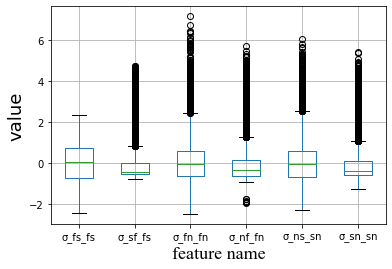

In [11]:
df[feature_columns].boxplot()
plt.gca().set_ylabel("value",fontdict={"size":18})
plt.gca().set_xlabel("feature name",fontdict={'family' : 'Times New Roman', 'size' : 18})
plt.xticks([1, 2, 3, 4, 5, 6], ['\u03C3_fs_fs', '\u03C3_sf_fs', '\u03C3_fn_fn','\u03C3_nf_fn','\u03C3_ns_sn','\u03C3_sn_sn'])
plt.show()

In [14]:
q_data,y_data=df.iloc[:,1:5],df.iloc[:,5:]


###################################
print(q_data,y_data)

            q1        q2        q3        q4
0     4.961442  2.385522  2.896893  0.806421
1     2.509299  3.074866  0.972012  4.125319
2     1.773326  0.717280  1.926991  1.375933
3     1.550003  0.337619  1.263067  3.412958
4     4.681192  1.154233  0.885567  4.695532
...        ...       ...       ...       ...
9992  0.628663  2.053099  3.287217  0.591565
9993  3.729453  3.783092  1.535259  1.773232
9994  4.037112  1.362884  2.088671  1.399348
9995  1.895636  0.827792  3.815292  4.884978
9996  1.000000  1.000000  1.000000  1.000000

[9997 rows x 4 columns]       alpha_vol  beta_vol  alpha_max  beta_max  alpha_min  beta_min
0      0.849632  0.073551   1.130316 -0.307393   0.951710 -0.154587
1      0.216017 -0.620037  -1.549780 -1.912316  -0.778712 -1.228686
2     -1.568797  0.632007  -0.900616  1.000382  -1.089484  1.009564
3     -1.928056  2.301986  -0.784633  2.772134  -1.022647  2.998850
4      0.186084  1.086046   0.814616  0.243445   1.184828  0.677617
...         ...       ...  

In [15]:
train_size=int(0.9*len(q_data))

In [16]:
q_data_train,q_data_test=q_data.iloc[:train_size,:],q_data.iloc[train_size:,:]
y_data_train,y_data_test=y_data.iloc[:train_size,:],y_data.iloc[train_size:,:]

In [17]:
q_data_exp,y_data_exp=q_data.iloc[-1,:].values.reshape((1,-1)),y_data.iloc[-1,:].values.reshape((1,-1))
print(y_data_exp)

[[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]


In [18]:
q_data_train.shape,q_data_test.shape,q_data_exp.shape,y_data_exp.shape

((8997, 4), (1000, 4), (1, 4), (1, 6))

In [19]:
q_data_exp

array([[1., 1., 1., 1.]])

In [20]:
class SklearnHelper(object):
    def __init__(self, clf, params=None,isMuilt_reg=False):
        if isMuilt_reg: self.clf= MultiOutputRegressor (clf(**params))
        else: self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def score(self,x,y):
        return self.clf.score(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [21]:
def mse_loss(y_true,y_pred):
    return np.mean(np.square(y_true-y_pred))

X = q_data_train.values
y = y_data_train.values
X_test = q_data_test.values
y_test=y_data_test.values

In [22]:
X.shape,y.shape,X_test.shape,y_test.shape

((8997, 4), (8997, 6), (1000, 4), (1000, 6))

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern,RationalQuadratic

In [24]:
start = timeit.default_timer()
## not yet finished
#kernel = ConstantKernel(100, (1e-3, 1e3))*Matern(length_scale= 100, length_scale_bounds=(0.0,1e4),nu=2.5)
kernel = ConstantKernel(100, (1e-3, 1e3))*RBF(length_scale= 1.0, length_scale_bounds=(0.0,100))
# kernel = RBF(**gpr_para[feat_flag])

gpr_models=[]
for feat_flag in range(6):
    gpr_sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_sub.fit(X, y[:, feat_flag])
    print(gpr_sub.kernel_)
    gpr_models.append(gpr_sub)
stop = timeit.default_timer()

print('Time: ', stop - start)

fitting feature 0
0.343**2 * RBF(length_scale=0.635)
fitting feature 1


KeyboardInterrupt: 

In [26]:
# predicting the output and others using the selected hyperparameters
for feat_flag in range(4):
    print('fitting feature %d' % feat_flag)
    gpr_sub = gpr_models[feat_flag]
    pred = gpr_sub.predict(X_test)
    print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_test[:, feat_flag], pred),metrics.r2_score(y_test[:, feat_flag], pred)))

fitting feature 0
gpr Test: mse loss=0.000692 r2_score=0.999304
fitting feature 1


IndexError: list index out of range

In [27]:
y_pred=np.zeros(y_test.shape)
for ix, model in enumerate(gpr_models):
    y_pred[:, ix] += model.predict(X_test)

for feat_flag in range(6):
    loss_test = mse_loss(y_test[:, feat_flag], y_pred[:, feat_flag])
    R2_test  = metrics.r2_score(y_test[:, feat_flag], y_pred[:, feat_flag])
    print('Test: mse loss={:.6f} r2_score={:.6f}'.format(loss_test, R2_test))

Test: mse loss=0.000692 r2_score=0.999304
Test: mse loss=0.949231 r2_score=-0.000040
Test: mse loss=0.886213 r2_score=-0.000102
Test: mse loss=0.944988 r2_score=-0.000198
Test: mse loss=0.927270 r2_score=-0.000410
Test: mse loss=0.958735 r2_score=-0.000001


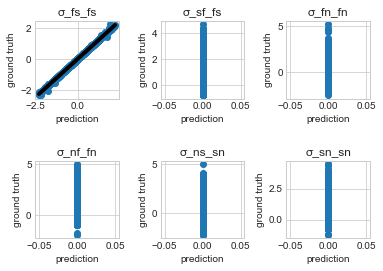

In [28]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.subplot(2,3,1)
feat_flag = 0;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('\u03C3_fs_fs')
#plt.show()

plt.subplot(2,3,2)
feat_flag = 1;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('\u03C3_sf_fs')
#plt.show()

plt.subplot(2,3,3)
feat_flag = 2;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('\u03C3_fn_fn')
#plt.show()

plt.subplot(2,3,4)
feat_flag = 3;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('\u03C3_nf_fn')
#plt.show()


plt.subplot(2,3,5)
feat_flag = 4;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('\u03C3_ns_sn')
#plt.show()

plt.subplot(2,3,6)
feat_flag = 5;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('\u03C3_sn_sn')
plt.subplots_adjust(wspace = 0.5)
plt.subplots_adjust(hspace=0.8)
plt.show()

